# Project: Write a Data Science Blog Post

The data obtained from the stack overflow survey can provide relevant insights for students, since based on the experiences and perceptions of developers, relevant conclusions can be drawn about the current state of each specialization. The following lines of code will seek to answer three questions of interest to new developers:

    - What is the most popular type of developer?: Ranking of the most popular types of developers.
    - What type of developers are most satisfied with their job?: Of all the types who are the most satisfied whit their jobs,
    - How about the salary?: Are the most satisfied whit their jobs better paid?

First is neccesary to import the following packages

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
pd.options.mode.chained_assignment = None  # default='warn'

### Gather Data

Importing the cvs files downloaded from https://www.kaggle.com/datasets/stackoverflow/so-survey-2017

In [160]:
#Reading files
df = pd.read_csv('C:/Users/50304252/Documents/Proyectos_Udacity/Datasets/StackOverflow_Dataset/survey_results_public.csv')
schema = pd.read_csv('C:/Users/50304252/Documents/Proyectos_Udacity/Datasets/StackOverflow_Dataset/survey_results_schema.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Assess Data

How many rows and columns are in df:

In [161]:
df.shape

(51392, 154)

Which columns had no missing values? Set of column names that have no missing values.

In [162]:
np.sum(df.isnull()) == 0

Respondent               True
Professional             True
ProgramHobby             True
Country                  True
University               True
                        ...  
QuestionsInteresting    False
QuestionsConfusing      False
InterestedAnswers       False
Salary                  False
ExpectedSalary          False
Length: 154, dtype: bool

How many missing values are in each column.

In [163]:
np.sum(df.isnull())

Respondent                  0
Professional                0
ProgramHobby                0
Country                     0
University                  0
                        ...  
QuestionsInteresting    16856
QuestionsConfusing      16973
InterestedAnswers       16780
Salary                  38501
ExpectedSalary          48826
Length: 154, dtype: int64

The only columns with no nan values are the following

In [164]:
no_nulls = set(df.columns[np.sum(df.isnull())==0])
no_nulls

{'Country',
 'EmploymentStatus',
 'FormalEducation',
 'Professional',
 'ProgramHobby',
 'Respondent',
 'University'}

### Clean Data

To answer the questions we need three columns; DeveloperType, JobSatisfaction and Salary. In the next line we took only this three columns for the analysis.

In [165]:
#Selecting columns of interest and cleaning Na values
df = df[['DeveloperType', 'JobSatisfaction', 'Salary']]

#### Approach to handle missing values


- The selected approach to mannage na values is to drop to avoid errors or biases that may arise when imputing or replacing missing values and preserve the original distribution and variance of the data.

- Finalmente, al ser este un analisis exploratorio no predictivo, no se corre el riesgo de contar con data set de entrenamiento y prueba muy pequeño

In [166]:
df = df.dropna()

Looking into DeveloperType column, many respondents identified whit many categories.
To know the popularity of every kind of developer is necessary to separate answers

In [167]:
#Looking into DeveloperType column, many respondents identified whit many categories.
#To know the popularity of every kind of developer is necessary to separate answers
DevType = df['DeveloperType'].value_counts().reset_index()
DevType

,index,DeveloperType
0,Web developer,3974
1,Web developer; Desktop applications developer,673
2,Desktop applications developer,539
3,Mobile developer,530
4,Web developer; Mobile developer,509
...,...,...
955,Developer with a statistics or mathematics bac...,1
956,Embedded applications/devices developer; Deskt...,1
957,Web developer; Embedded applications/devices d...,1
958,Web developer; Machine learning specialist; De...,1


### Analyze and Model

In the next cells we define two functions to help in the process of separte and quantify the kinds the answers in the columns DeveloperType with the function total_func an plot the results with the function clean_and_plot.

In [168]:
# All te possible types of developer
possible_vals = ['Web developer','Mobile developer','Desktop applications developer','Other',
                 'Embedded applications/devices developer','Developer with a statistics or mathematics background',
                 'Data scientist','DevOps specialist','Quality assurance engineer','Machine learning specialist',
                 'Graphics programming','Database administrator','Systems administrator','Graphic designer']

#function to  separate types of developer
def total_func(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count/sum values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count or sum of df[col2]
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the value is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])

                
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values(col2, ascending=False, inplace=True)
    return new_df


In [169]:
#fuction to plot new df
def clean_and_plot(df, title, plot=True):
    '''
    INPUT 
        df - a dataframe holding the column name you want to look through
        title - string the title of your plot   
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        DevTypes_df - a dataframe with the count/sum of col2
    '''

    df.set_index(list(df.columns)[0], inplace=True)
    if plot:
        (df/df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_DevTypes_df = df/df.sum()
    return props_DevTypes_df
    


In the next  cell using the function total_func we creat a DevTypes_df Data Frame, in this we want to quantify the total developers per type.

In [184]:
#Creating DevTypes_df to group echar type of developer and their popularity
Count_DevType = df['DeveloperType'].value_counts().reset_index()
#Renamming columns
Count_DevType.rename(columns={'index': 'Developer', 'DeveloperType': 'Count'}, inplace=True)
#Ussing total_func to separte each type developer in every respondent answer
DevTypes_df = total_func(Count_DevType, 'Developer', 'Count', possible_vals)

In the next  cell using the function total_func we creat a JobS_DevType_df Data Frame, in this we want to know the average job satisfaction for each developer.
Then we merge this new data frame with DevTypes_df_idx (same data frame DevTypes_df with reset index)

In [186]:
#Reset index DevTypes_df, Developer column must be new index to use merge method.
DevTypes_df_idx = DevTypes_df.set_index('Developer')

#Creating JobS_DevType df to know job satisfaction of each type of developer
JobS_DevType = df.groupby('DeveloperType')['JobSatisfaction'].sum().reset_index()

#We rename columns using the rename method
JobS_DevType.rename(columns={'DeveloperType': 'Developer', 'JobSatisfaction': 'JobSatisfaction_Sum'}, inplace=True)

#Using total_func function to sum all the job satisfacction answers.
JobS_DevType_df = total_func(JobS_DevType, 'Developer', 'JobSatisfaction_Sum', possible_vals)

#Set new index
JobS_DevType_df.set_index('Developer', inplace = True)

#Merging DevTypes_df and JobS_DevType into df_f
df_f = pd.merge(DevTypes_df_idx,JobS_DevType_df,left_index=True, right_index=True)

#Calculating job satisfaction average, JobSatisfaction_Sum / total Respondent
df_f['Avg_JobSatisfaction'] = df_f['JobSatisfaction_Sum'] / df_f ['Count']

In [189]:
#Creating Salary_DevType_df df to know job salary of each type of developer
Salary_DevType = df.groupby('DeveloperType')['Salary'].sum().reset_index()

#We rename columns using the rename method
Salary_DevType.rename(columns={'DeveloperType': 'Developer', 'Salary': 'Salary_Sum'}, inplace=True)

#Using total_func function to sum all the salaries answers.
Salary_DevType_df = total_func(Salary_DevType, 'Developer', 'Salary_Sum', possible_vals)

#Set new index
Salary_DevType_df.set_index('Developer', inplace = True)

#Mergin Salary_DevType_df and df_f and creating df_final
df_final = pd.merge(df_f,Salary_DevType_df,left_index=True, right_index=True)
df_final['Avg_Salary_per_Type'] = df_final['Salary_Sum']/df_final['Count']

In [190]:
#Calculating average salary of each kind of developer
df_final['Avg_Salary_Total'] = df_final['Avg_Salary_per_Type'].mean()
df_final['Dif_avg_salary'] =  df_final['Avg_Salary_per_Type'] - df_final['Avg_Salary_Total'] 
df_final['%Dif_avg_salary'] = df_final['Dif_avg_salary']/df_final['Avg_Salary_per_Type']

## Visualize

### What is the most popular type of developer?


To answer this question it was necessary to separete the differente categories of developpers answer by the respondante. Using total_func and clean_and_plot we can achive that. Then we plot the results.

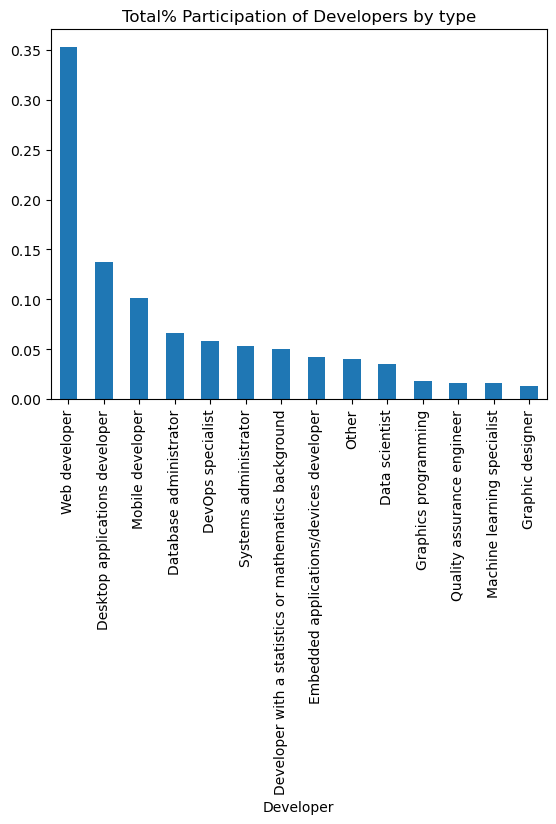

,Count
Developer,
Web developer,0.352840
Desktop applications developer,0.137345
Mobile developer,0.101085
Database administrator,0.065876
DevOps specialist,0.057806
Systems administrator,0.053264
Developer with a statistics or mathematics background,0.050561
Embedded applications/devices developer,0.041965
Other,0.040014


In [194]:
title='Total% Participation of Developers by type'
clean_and_plot(DevTypes_df,title,plot=True)

- There are a lot of web developers in this survey, more than a thir of the respondent.

### What type of developers are most satisfied with their job?

To adress this question we are going create a new df df_JobSatisfaction and column Dif_Avg_Satisfaction, to measure the difference between columns Avg_JobSatisfaction minus mean value of the same column, then to help to answer the question we assign colors (negative diferece: red, developer who earn less than the average, postive diference: green, developer who earn more than the average)

In [191]:
#Calculating the difference between job satisfaction of each type and average job satisfaction of all respondents
df_JobSatisfaction = df_final[['Avg_JobSatisfaction']]
df_JobSatisfaction.loc[:,'Dif_Avg_Satisfaction'] = df_JobSatisfaction.loc[: ,'Avg_JobSatisfaction'] - df_final['Avg_JobSatisfaction'].mean()

In [192]:
df_JobSatisfaction.style.bar(subset=['Dif_Avg_Satisfaction'], align='mid', color=['#d65f5f', '#5fba7d'])

,Avg_JobSatisfaction,Dif_Avg_Satisfaction
Developer,,
Web developer,6.953511,-0.059036
Desktop applications developer,6.875649,-0.136897
Mobile developer,7.047159,0.034613
Database administrator,6.896296,-0.116250
DevOps specialist,7.142208,0.129662
Systems administrator,6.937280,-0.075266
Developer with a statistics or mathematics background,6.962880,-0.049666
Embedded applications/devices developer,6.909660,-0.102886
Other,7.173546,0.161000


- The top categories whit higher values of job satisfaction are: Other, DevOps specialist, Machine learning specialist, Graphics programming.
- The categories whit less job satisfaction are: Desktop applications developer and Graphic designer	

### How about the salary?

To answer this question we calculate de percentage difference between the average salary for each type of developer and the mean average value and plot the result.

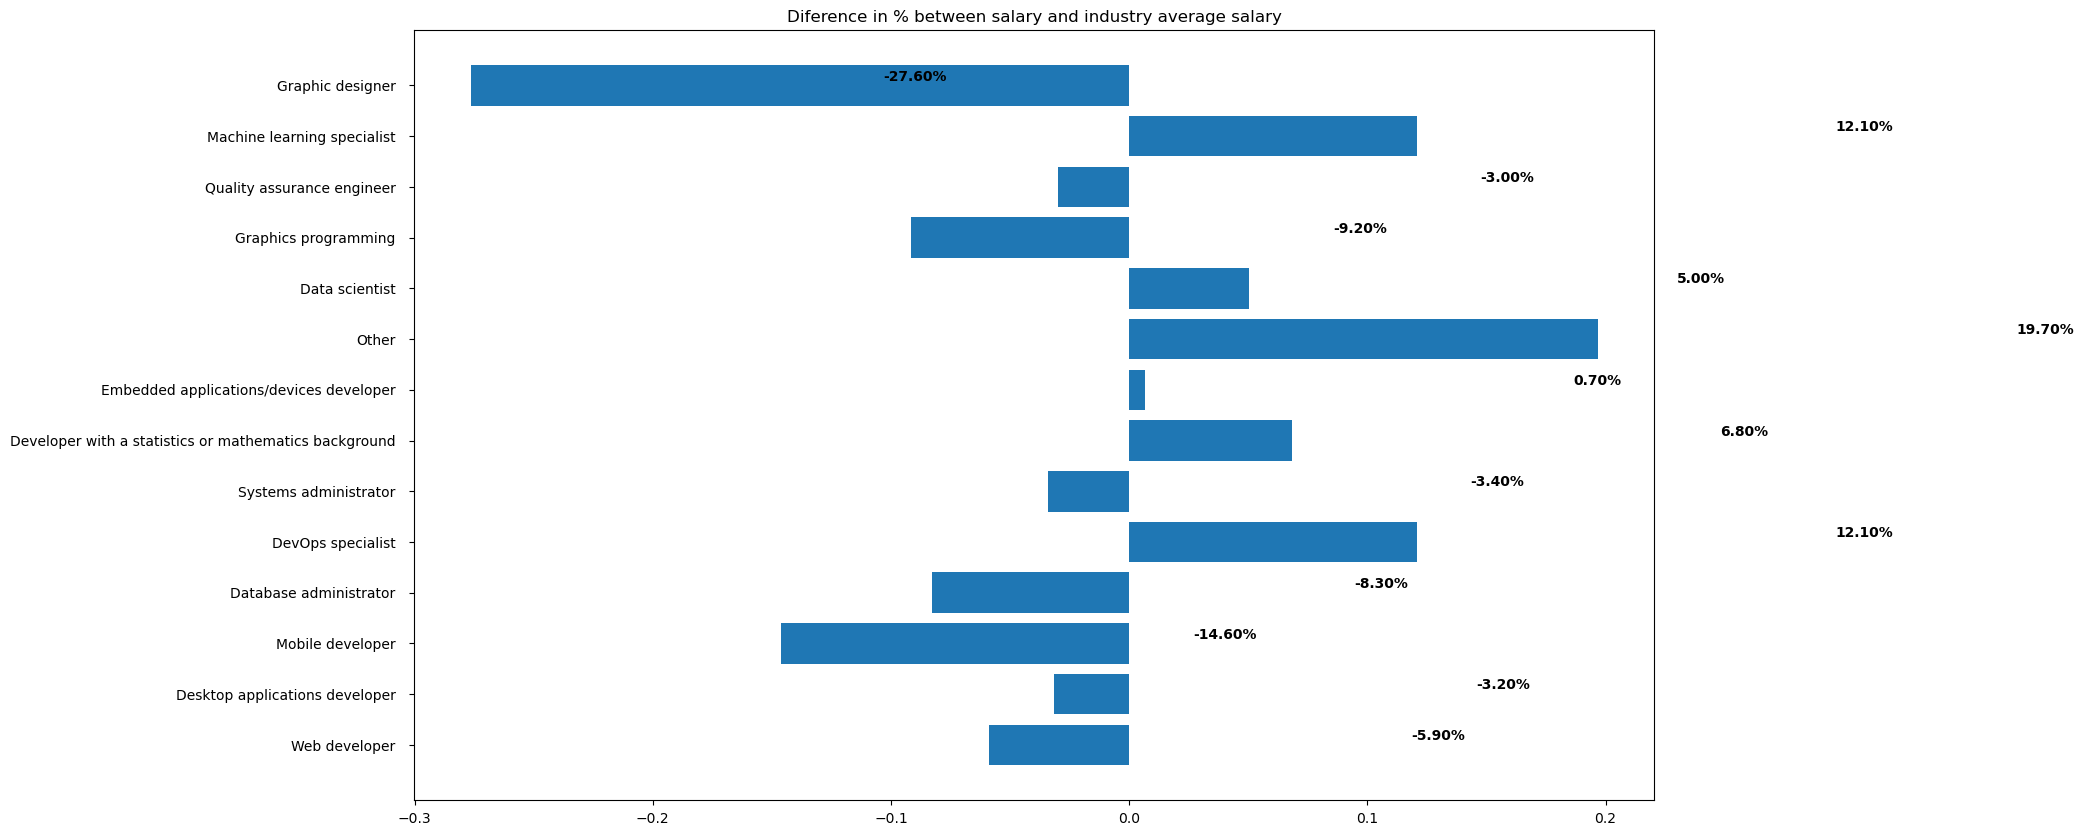

In [193]:
#Calculating the difference between average salary of each type and average average salary of all respondents
Developers = df_final.index
Avg_prc_Dif = df_final['%Dif_avg_salary']
fig, ax = plt.subplots(figsize =(16, 10))
ax.barh(Developers, Avg_prc_Dif)

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
plt.title('Diference in % between salary and industry average salary')
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             '{:.2%}'.format(round((i.get_width()), 3)),
    fontsize = 10, fontweight ='bold',
    color ='black',
    ha = 'right')

- The categories whit higher earning are similar to those with higher values of job satisfaction, thera are: Other, DevOps  specialist, Machine learning specialist. 
- Graphic designers have less job satisfaction and earn much less than the average, almost 28% less.
- Web developer are noumeroues, however they earn less than average